# **Age Detection with OpenCV**

![대체 텍스트](https://www.pyimagesearch.com/wp-content/uploads/2020/04/opencv_age_detection_examples.jpg)

ypically, you’ll see age detection implemented as a two-stage process:



1.   Detect faces in the input image/video stream
2.   Extract the face Region of Interest (ROI), and apply the age detector algorithm to predict the age of the person

Age detector modle

![대체 텍스트](https://www.pyimagesearch.com/wp-content/uploads/2020/04/opencv_age_detection_arch.png)

# Data Load of image, video and model


Download the pre-trained detection models, consisting of under files:


1.   Face Detection Model
2.   Age Detection Model
3.   Gender Detection Model




In [6]:
%%shell
mkdir ageDetection; cd ageDetection
mkdir model; cd model
curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Model/face_deploy.prototxt 
curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Model/face_deploy.caffemodel

curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Model/age_deploy.prototxt
curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Model/age_deploy.caffemodel

curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Model/gender_deploy.prototxt
curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Model/gender_deploy.caffemodel

cd ..; mkdir images; cd images
curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Images/jangnara.jpg 
curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Images/jangnara2.jpg 


mkdir: cannot create directory ‘ageDetection’: File exists
mkdir: cannot create directory ‘model’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   162  100   162    0     0   1408      0 --:--:-- --:--:-- --:--:--  1408
100 28092  100 28092    0     0   133k      0 --:--:-- --:--:-- --:--:--  133k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0    976      0 --:--:-- --:--:-- --:--:--   976
100 10.1M  100 10.1M    0     0  15.2M      0 --:--:-- --:--:-- --:--:-- 40.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   161  100   161    0     0    969      0 --:--:-- --:--:-- --:--:--   975
100  2308  100  2308

In [2]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os

In [7]:
# Root directory 
ROOT_DIR = os.path.abspath("./ageDetection/")
# Model directory 
MODEL_DIR = os.path.join(ROOT_DIR, "model")
# Images directory
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

#Face
prototxtPath = os.path.sep.join([MODEL_DIR, "face_deploy.prototxt"])  
weightsPath = os.path.sep.join([MODEL_DIR, "face_deploy.caffemodel"]) 
faceNet = cv2.dnn.readNetFromCaffe(prototxtPath, weightsPath)

#Age
prototxtPath = os.path.sep.join([MODEL_DIR, "age_deploy.prototxt"])  
weightsPath = os.path.sep.join([MODEL_DIR, "age_deploy.caffemodel"]) 
ageNet = cv2.dnn.readNetFromCaffe(prototxtPath, weightsPath)

#Gender
prototxtPath = os.path.sep.join([MODEL_DIR, "gender_deploy.prototxt"])  
weightsPath = os.path.sep.join([MODEL_DIR, "gender_deploy.caffemodel"]) 
genderNet = cv2.dnn.readNetFromCaffe(prototxtPath, weightsPath)

In [8]:
#Age and Gender classification list
AGE_LIST = ["(0-2)", "(4-6)", "(8-12)", "(15-20)", "(25-32)", "(38-43)", "(48-53)", "(60-100)"]
GENDER_LIST = ['Male', 'Female']
conf_threshold = 0.5

# **1**.Detection model demo by picture

In [9]:
# Load images
image_list = []
detections_list = [] 
for file in os.listdir(IMAGE_DIR):
  file_path = os.path.join(IMAGE_DIR, file)
  if(os.path.isfile(file_path)): 
    image = cv2.imread(file_path)    
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))
    faceNet.setInput(blob)
    detections = faceNet.forward()
    image_list.append(image)
    detections_list.append(detections)

In [11]:
for i, detections in enumerate(detections_list):
  for j in range(0, detections.shape[2]):
    (high, width) = image_list[i].shape[:2]

    confidence = detections[0, 0, j, 2] 
    if confidence > conf_threshold:

      # extract the ROI of the face
      box = detections[0, 0, j, 3:7] * np.array([width, high, width, high])    
      (startX, startY, endX, endY) = box.astype("int")
      face = image_list[i][startY:endY, startX:endX]
      faceBlob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),(78.4263377603, 87.7689143744, 114.895847746),swapRB=False)

      #Age prediction and display
      ageNet.setInput(faceBlob)
      pred1 = ageNet.forward()
      arg = pred1[0].argmax()
      age = AGE_LIST[arg]
      ageConfidence = pred1[0][arg]
      ageText = "{}: {:.2f}%".format(age, ageConfidence * 100)
    
      #Gender prediction and display
      genderNet.setInput(faceBlob)
      pred2 = genderNet.forward()
      arg = pred2[0].argmax()
      gender = GENDER_LIST[arg]
      genderConfidence = pred2[0][arg]
      genderText = "{}: {:.2f}%".format(gender, genderConfidence * 100)


      # draw the bounding box of the face along with the associated probability
      y = startY - 30 if startY - 30 > 30 else startY + 30
      cv2.rectangle(image_list[i], (startX, startY), (endX, endY), (0, 0, 255), 2)
      cv2.putText(image_list[i], genderText, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
      cv2.putText(image_list[i], ageText, (startX, y+15),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

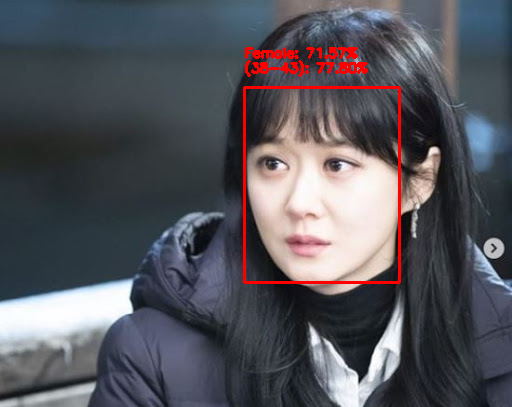

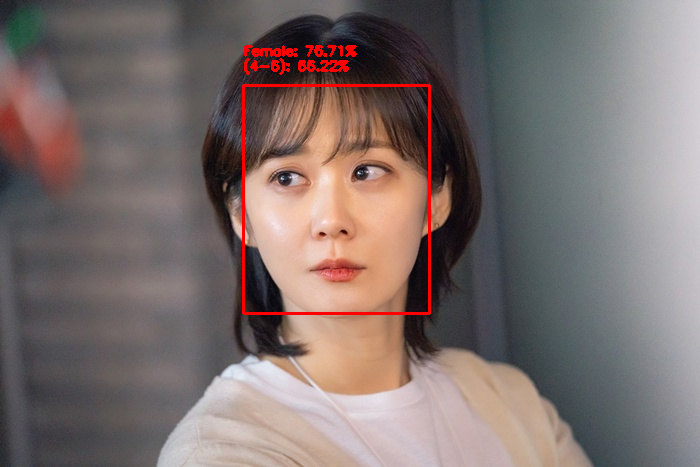

In [12]:
# show the output image
for image in image_list:
  cv2_imshow(image)

# **2**.Detection model demo by video

In [13]:
%%shell
cd ageDetection
mkdir videos; cd videos
curl -LJO https://github.com/phoebe81/DetectionWithOpenCV/raw/master/Videos/JJANG.mp4
cd videos
mkdir save

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   152  100   152    0     0    672      0 --:--:-- --:--:-- --:--:--   672
100  769k  100  769k    0     0  1165k      0 --:--:-- --:--:-- --:--:-- 3771k
/bin/bash: line 3: cd: videos: No such file or directory


In [14]:
VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")

## Processing Funtions

In [15]:
import base64, logging
import numpy as np
from PIL import Image
from io import BytesIO

def data_uri_to_img(uri):
  try:
    image = base64.b64decode(uri.split(',')[1], validate=True)
    # make the binary image, a PIL image
    image = Image.open(BytesIO(image))
    # convert to numpy array
    image = np.array(image, dtype=np.uint8); 
    return image
  except Exception as e:
    logging.exception(e);print('\n')
    return None

def video_to_data_url(filename):
    ext = filename.split('.')[-1]
    prefix = 'data:video/{};base64,'.format(ext)
    with open(filename, 'rb') as f:
        vidoe = f.read()
    return prefix + base64.b64encode(vidoe).decode()

In [16]:
def detect_and_predict_age(frame):
  (high, width) = frame.shape[:2]
  blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),(104.0, 177.0, 123.0))
		
  faceNet.setInput(blob)
  detections = faceNet.forward()

  for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > conf_threshold:

			# extract the ROI of the face
      box = detections[0, 0, i, 3:7] * np.array([width, high, width, high])
      (startX, startY, endX, endY) = box.astype("int")			
      face = frame[startY:endY, startX:endX]			
      if face.shape[0] < 20 or face.shape[1] < 20:
        continue
      faceBlob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),(78.4263377603, 87.7689143744, 114.895847746),swapRB=False)

			#Age prediction and display
      ageNet.setInput(faceBlob)
      preds = ageNet.forward()
      arg = preds[0].argmax()
      age = AGE_LIST[arg]
      ageConfidence = preds[0][arg]
      ageText = "{}: {:.2f}%".format(age, ageConfidence * 100)

			#Gender prediction and display
      genderNet.setInput(faceBlob)
      preds = genderNet.forward()
      arg = preds[0].argmax()
      gender = GENDER_LIST[arg]
      genderConfidence = preds[0][arg]
      genderText = "{}: {:.2f}%".format(gender, genderConfidence * 100)

			# draw the bounding box of the face along with the associated probability
      y = startY - 30 if startY - 30 > 30 else startY + 30
      cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)
      cv2.putText(frame, genderText, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
      cv2.putText(frame, ageText, (startX, y+15),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

## Videdo Capture
Using a webcam to capture images for processing on the runtime.
Source: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi

In [17]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# playing webcam or video with javascript
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''     
    async function takePhoto(filename, quality) {
                  
      const div = document.createElement('div');
      document.body.appendChild(div);

      const exit = document.createElement('button');
      exit.textContent = 'Exit';
      div.appendChild(exit);

      const video = document.createElement('video');
      video.style.display = 'block';
           
      if('photo.jpg' == filename){
        const stream = await navigator.mediaDevices.getUserMedia({video: true}); 
        video.srcObject = stream;   
      }else{
        video.src = filename;
        video.type="video/mp4"
      }
      await video.play();  
      div.appendChild(video);       
                   

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      
      let jsLog = function(abc) {
        document.querySelector("#output-area").appendChild(document.createTextNode(`${abc}... `));
      }

      // when Exit button is clicked.   
      var isOpened = true; 
      var exitPromise = new Promise((resolve) => {exit.onclick = resolve});   
      exitPromise.then(()=>{isOpened = false; stream.getVideoTracks()[0].stop();});
      
      //when end of video
      var endPromise = new Promise((resolve) => {video.onended = resolve});   
      endPromise.then(()=>{isOpened = false; video.stop();});

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;

      for (let i = 0; isOpened; i++) {
        canvas.getContext("2d").clearRect(0, 0, canvas.width, canvas.height);
        canvas.getContext('2d').drawImage(video, 0, 0);
        img = canvas.toDataURL('image/jpeg', quality);

        // jsLog(i + "sending");
        // Call a python function and send this image
        google.colab.kernel.invokeFunction('notebook.run_ageDetection', [img], {});
        // jsLog(i + "SENT");

        // wait for X miliseconds second, before next capture
        await new Promise(resolve => setTimeout(resolve, 250));        
      }       
      div.remove();      
    }    
    ''')  
  # make the provided HTML, part of the cell
  display(js)
  #call the takePhoto() JavaScript function
  eval_js('takePhoto({},{})'.format("'"+filename+"'", quality)) 

In [18]:
from google.colab import output
frame_count = 0
writer = None

# InvokeFunction
# takes the numpy image and runs detection, then shows the results by visualizing
def run_ageDetection(uri): 
  global frame_count, writer

  image = data_uri_to_img(uri)     
  if writer is None:		
      fourcc = cv2.VideoWriter_fourcc(*'DIVX')  
      writer = cv2.VideoWriter(outVideo, fourcc, 2, (image.shape[1], image.shape[0]), True)
  try:        
    detect_and_predict_age(image)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    frame_count+=1    
    name = '{0}.jpg'.format(frame_count)
    name = os.path.join(VIDEO_SAVE_DIR, name)
    cv2.imwrite(name, image)

    if writer is not None:
      writer.write(image)
  except Exception as e:
    logging.exception(e)
    print('\n')

# register this function, so JS code could call this
output.register_callback('notebook.run_ageDetection', run_ageDetection)

## Apply Detection model

In [23]:
 %%shell
 cd ageDetection
 rm ./videos/save/* 
 rm ./videos/out.avi

In [20]:
inVideo = os.path.join(VIDEO_DIR, "JJANG.mp4")
outVideo= os.path.join(VIDEO_DIR, "out.avi")

In [24]:
frame_count = 0
data_url = video_to_data_url(inVideo)
try: 
  # put the JS code in cell and run it
  take_photo(data_url)  
  if writer is not None:
    writer.release()   
except Exception as e:
  logging.exception(e)
  print('\n')

writer = None

<IPython.core.display.Javascript object>

## Downlod  to our local machine

In [25]:
from google.colab import files
files.download(outVideo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>